In [4]:
import os
import sys

image_dir_path = './../images'
target_image_name = 'eye.jpg'
target_image_path = os.path.join(image_dir_path, target_image_name)

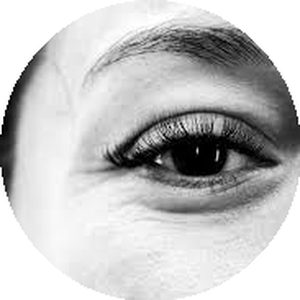

In [5]:
from PIL import Image, ImageDraw, ImageOps

def crop_grayscale_to_circle(input_path, target_size):
    # 画像を読み込み
    img = Image.open(input_path)

    # 画像をグレースケールに変換
    img = img.convert('L')

    # 画像を正方形に切り抜く
    size = min(img.size)
    img = ImageOps.fit(img, (size, size), Image.LANCZOS)

    # 円形に切り抜くためのマスクを作成
    mask = Image.new('L', (size, size), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0, size, size), fill=255)

    # マスクを使って画像を円形に切り抜く
    img = Image.composite(img, Image.new('L', img.size, 255), mask)

    # 指定されたサイズにリサイズ
    img = img.resize((target_size, target_size), Image.LANCZOS)

    # 切り抜かれた画像を返す
    return img

# 使用例
input_image_path = './../images/eye.jpg'  # 入力画像のパス
converted_image = crop_grayscale_to_circle(input_image_path, 300)

converted_image

(500, 500) 500


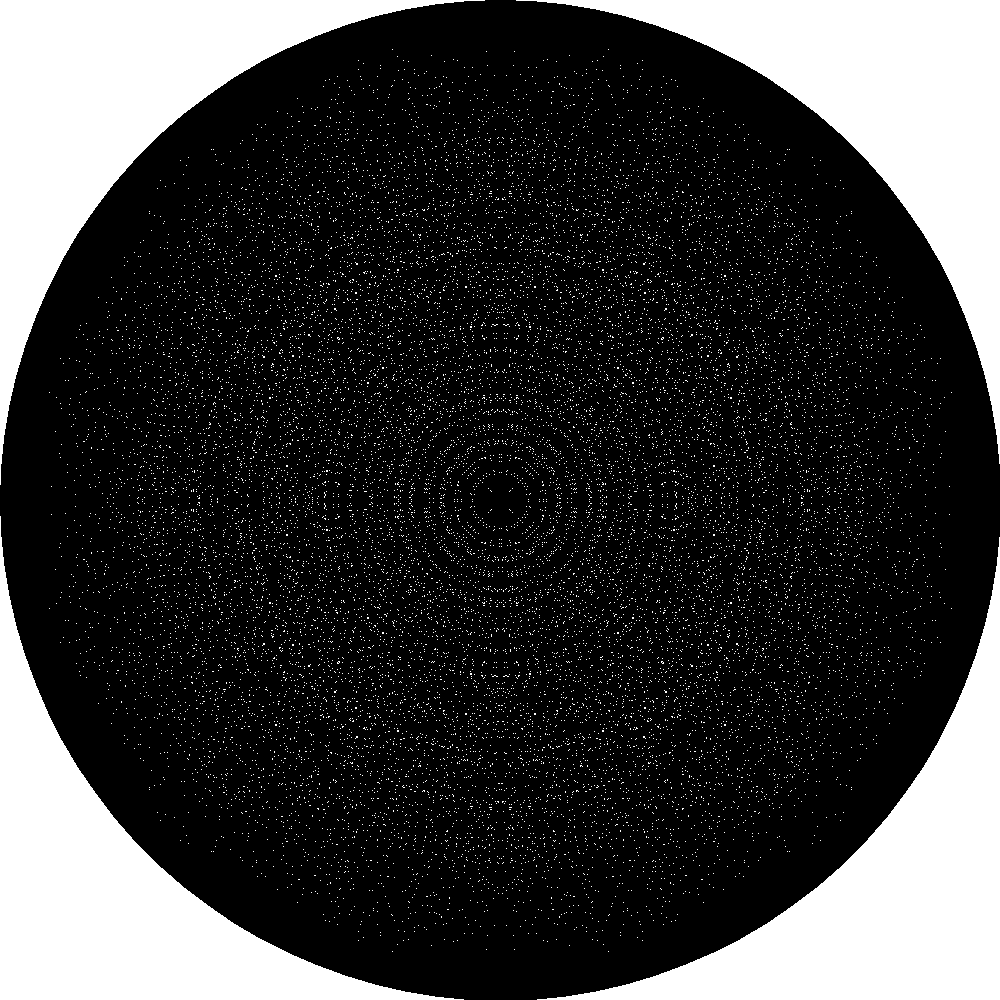

In [3]:
import math
from PIL import Image, ImageDraw

# キャンパスを作成
img = Image.new('L', (1000, 1000), 255)
draw = ImageDraw.Draw(img)

# 正方形に内接する円の中心座標と半径を計算
center = (img.size[0] // 2, img.size[1] // 2)
radius = min(img.size) // 2

print(center, radius)

num_points = 100

def approximate_circle_points(center, radius, num_points):
    points = []
    for i in range(num_points):
        angle = (2 * math.pi * i) / num_points
        x = center[0] + int(radius * math.cos(angle))
        y = center[1] + int(radius * math.sin(angle))
        points.append((x, y))
    return points

# 円上の点を近似
circle_points = approximate_circle_points(center, radius, num_points)

circle_coord_dict = {}

for i, circ_point in enumerate(circle_points):
    circle_coord_dict[i] = circ_point

circle_coord_dict # n C 2 

target_list = circle_coord_dict
combinations = []

for i in range(len(target_list)):
    for j in range(i + 1, len(target_list)):
        combinations.append((i, j))

for a, b in combinations:
    point1 = circle_coord_dict[a]
    point2 = circle_coord_dict[b]

    draw.line([point1, point2], fill=0, width=1)

img


In [11]:
(1, (2, 3), np.array([1, 2, 3]))

(1, (2, 3), array([1, 2, 3]))

In [10]:
import numpy as np

In [15]:
tmp = {1: 2, 2:3}
tmp

{1: 2, 2: 3}

In [ ]:
class Config:
    def __init__(self,
                 )

In [17]:
from typing import Tuple

class BasisVector:
    def __init__(self, 
                 pair_ids: Tuple[int],
                 pair_coordinates: Tuple[Tuple[int]]):
        self.pair_ids = pair_ids
        self.pair_coordinates = pair_coordinates
        self.vector_representation = self._get_vector_representation()

    def _get_vector_representation(self):
git
    def __add__
        

KeyError: '1'

In [18]:
(None, None)

(None, None)